In [412]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import metrics
from sklearn.model_selection import cross_val_score, train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor

In [413]:
#設定 data_path
dir_data = './data'
f_train = os.path.join(dir_data, 'train_data.csv')
f_test =  os.path.join(dir_data, 'test_features.csv')

EnronFraud_train = pd.read_csv(f_train)
EnronFraud_test = pd.read_csv(f_test)

EnronFraud_train_Labels = EnronFraud_train['poi']
names = EnronFraud_test['name']
EnronFraud_train = EnronFraud_train.drop(['name', 'poi'], axis = 1)
EnronFraud_test = EnronFraud_test.drop(['name'], axis = 1)

EnronFraud = pd.concat([EnronFraud_train, EnronFraud_test])
EnronFraud.head()

,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,loan_advances,long_term_incentive,other,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
0,1750000.0,NaN,-3504386.0,NaN,ken.rice@enron.com,19794175.0,46950.0,18.0,42.0,4.0,NaN,1617011.0,174839.0,2748364.0,NaN,420636.0,864.0,905.0,505050.0,22542539.0
1,5600000.0,NaN,NaN,NaN,jeff.skilling@enron.com,19250000.0,29336.0,108.0,88.0,30.0,NaN,1920000.0,22122.0,6843672.0,NaN,1111258.0,2042.0,3627.0,8682716.0,26093672.0
2,200000.0,NaN,-4167.0,NaN,rex.shelby@enron.com,1624396.0,22884.0,39.0,13.0,14.0,NaN,NaN,1573324.0,869220.0,NaN,211844.0,91.0,225.0,2003885.0,2493616.0
3,800000.0,NaN,NaN,NaN,michael.kopper@enron.com,NaN,118134.0,NaN,NaN,NaN,NaN,602671.0,907502.0,985032.0,NaN,224305.0,NaN,NaN,2652612.0,985032.0
4,1250000.0,NaN,-262500.0,NaN,christopher.calger@enron.com,NaN,35818.0,144.0,199.0,25.0,NaN,375304.0,486.0,126027.0,NaN,240189.0,2188.0,2598.0,1639297.0,126027.0


In [414]:
# EDA
EnronFraud.dtypes.value_counts()

float64    19
object      1
dtype: int64

In [415]:
EnronFraud.select_dtypes(include = ['object']).apply(pd.Series.nunique, axis = 0)

email_address    111
dtype: int64

In [416]:
#因唯一的類別型欄位email，對結果應較無影響, 所以只篩選出數值型特徵, 放於num_features 中
num_features = []
for dtype, feature in zip(EnronFraud.dtypes, EnronFraud.columns):
    if dtype == 'float64' or dtype == 'int64':
        num_features.append(feature)

In [417]:
# 只取用數值型欄位
EnronFraud = EnronFraud[num_features]
train_num = EnronFraud_train_Labels.shape[0]
EnronFraud.head()

,bonus,deferral_payments,deferred_income,director_fees,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,loan_advances,long_term_incentive,other,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
0,1750000.0,NaN,-3504386.0,NaN,19794175.0,46950.0,18.0,42.0,4.0,NaN,1617011.0,174839.0,2748364.0,NaN,420636.0,864.0,905.0,505050.0,22542539.0
1,5600000.0,NaN,NaN,NaN,19250000.0,29336.0,108.0,88.0,30.0,NaN,1920000.0,22122.0,6843672.0,NaN,1111258.0,2042.0,3627.0,8682716.0,26093672.0
2,200000.0,NaN,-4167.0,NaN,1624396.0,22884.0,39.0,13.0,14.0,NaN,NaN,1573324.0,869220.0,NaN,211844.0,91.0,225.0,2003885.0,2493616.0
3,800000.0,NaN,NaN,NaN,NaN,118134.0,NaN,NaN,NaN,NaN,602671.0,907502.0,985032.0,NaN,224305.0,NaN,NaN,2652612.0,985032.0
4,1250000.0,NaN,-262500.0,NaN,NaN,35818.0,144.0,199.0,25.0,NaN,375304.0,486.0,126027.0,NaN,240189.0,2188.0,2598.0,1639297.0,126027.0


 ### 高於群體者可能poi會是true, 先都不移除outlier

In [418]:
#檢查欄位缺值數量
EnronFraud.isnull().sum().sort_values().head()

total_stock_value          20
total_payments             21
restricted_stock           36
exercised_stock_options    44
salary                     51
dtype: int64

In [419]:
# 補空值方法1: 補 0
EnronFraud_0 = EnronFraud.fillna(0)
EnronFraud_train_0 = EnronFraud_0[:train_num]

estimator = GradientBoostingClassifier(random_state = 1)
cross_val_score(estimator, EnronFraud_train_0, EnronFraud_train_Labels, cv=5).mean()

0.8581027667984189

In [421]:
# 補空值方法3: 補 平均值
EnronFraud_mn  = EnronFraud.fillna(EnronFraud.mean())
EnronFraud_train_mn = EnronFraud_mn[:train_num]

estimator = GradientBoostingClassifier(random_state = 1)
cross_val_score(estimator, EnronFraud_train_mn, EnronFraud_train_Labels, cv=5).mean()

0.8312252964426877

In [422]:
# 補空值方法4: 補 中位數
EnronFraud_mdn  = EnronFraud.fillna(EnronFraud.median())
EnronFraud_train_mdn = EnronFraud_mdn[:train_num]

estimator = GradientBoostingClassifier(random_state = 1)
cross_val_score(estimator, EnronFraud_train_mdn, EnronFraud_train_Labels, cv=5).mean()

0.8494071146245059

In [423]:
# 綜合方法A: 空值補 0 且用 MMEncoder
EnronFraud_0 = EnronFraud.fillna(0)
EnronFraud_0_MM = MinMaxScaler().fit_transform(EnronFraud_0)
EnronFraud_train_0_MM = EnronFraud_0_MM[:train_num]

estimator = GradientBoostingClassifier(random_state = 1)
cross_val_score(estimator, EnronFraud_train_0_MM, EnronFraud_train_Labels, cv=5).mean()

0.8581027667984189

In [425]:
# 綜合方法B: 空值補 0 且用 SSEncoder
EnronFraud_0 = EnronFraud.fillna(0)
EnronFraud_0_SS = StandardScaler().fit_transform(EnronFraud_0)
EnronFraud_train_0_SS = EnronFraud_0_SS[:train_num]

estimator = GradientBoostingClassifier(random_state = 1)
cross_val_score(estimator, EnronFraud_train_0_SS, EnronFraud_train_Labels, cv=5).mean()

0.8581027667984189

In [426]:
#選擇用0補空值(也較合理, 代表無此金額)
EnronFraud  = EnronFraud.fillna(0)

#使用標準化 或 最大最小化)
#因EDA發現欄位大部分都有極端值 且不去除  所以使用標準化比較適合
SSEncoder = StandardScaler()
for c in EnronFraud.columns:
    EnronFraud[c] = EnronFraud[c].fillna(0)
    EnronFraud[c] = SSEncoder.fit_transform(EnronFraud[c].values.reshape(-1, 1))
EnronFraud.head()


EnronFraud_train = EnronFraud[:train_num]

In [427]:
# 隨機森林擬合後, 將結果依照重要性由高到低排序
estimator = GradientBoostingClassifier()
estimator.fit(EnronFraud_train, EnronFraud_train_Labels)
feats = pd.Series(data = estimator.feature_importances_, index = EnronFraud_train.columns)
feats = feats.sort_values(ascending = False)
feats

exercised_stock_options      0.357545
expenses                     0.199323
total_payments               0.116386
other                        0.111444
bonus                        0.083437
deferred_income              0.036016
restricted_stock             0.021925
salary                       0.017593
from_this_person_to_poi      0.014402
long_term_incentive          0.010911
shared_receipt_with_poi      0.009519
to_messages                  0.008452
total_stock_value            0.007544
from_poi_to_this_person      0.002338
loan_advances                0.001509
from_messages                0.000888
deferral_payments            0.000767
director_fees                0.000000
restricted_stock_deferred    0.000000
dtype: float64

In [428]:
#只選擇特徵重要性前五名 可提升cross val scor約6%
high_feature = list(feats[:5].index)

estimator = GradientBoostingClassifier()
cross_val_score(estimator, EnronFraud_train[high_feature], EnronFraud_train_Labels, cv=5).mean()

0.9197628458498024

In [429]:
#整體資料集只選擇特徵重要性前五名的特徵
EnronFraud = EnronFraud[high_feature]

Numbers of remain columns 5


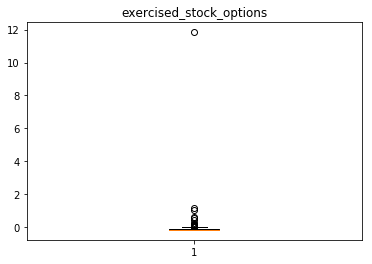

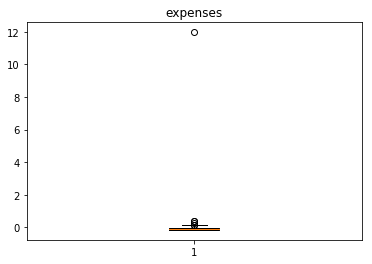

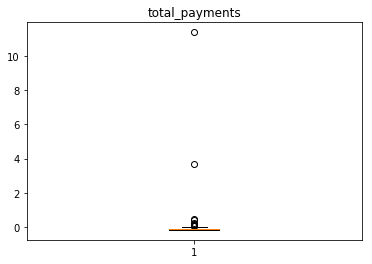

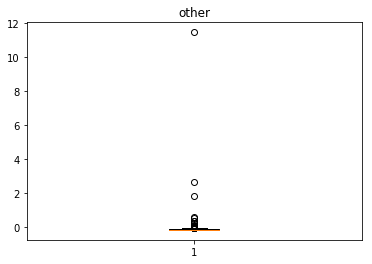

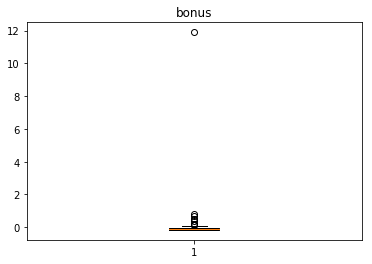

In [430]:
# 用boxplot 觀察各欄位離群值
print("Numbers of remain columns %s" % len(high_feature))
for col in high_feature:
    plt.boxplot(EnronFraud[col])
    plt.title(col)
    plt.show()

In [431]:
EnronFraud_train = EnronFraud[:train_num]

In [432]:
#把training set切分訓練集、驗證集,以避免testing set 在切分為public& private得出的預測結果差距過大
x_train, x_val, y_train, y_val= train_test_split(EnronFraud_train, EnronFraud_train_Labels, test_size = 0.25, random_state = 4)
x_train.shape

(84, 5)

In [437]:
#設定要訓練的超參數組合
n_estimators = [100, 200, 300]
max_depth = [1, 3, 5]
para_grid = dict(n_estimators = n_estimators, max_depth = max_depth)

#建立模型
clf = GradientBoostingClassifier(random_state=0)

#建立搜尋物件,放入模型與超參數組合字典
grid_search = GridSearchCV(clf, para_grid, scoring = 'roc_auc', n_jobs = -1, verbose= 1)

#開始搜尋最佳參數
grid_result = grid_search.fit(x_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:   12.6s finished


In [439]:
#印出最佳結果,最佳參數
print("Best auc : %f using %s" %(grid_result.best_score_, grid_result.best_params_))

Best auc : 0.751111 using {'max_depth': 1, 'n_estimators': 100}


In [445]:
#使用最佳參數重新建立模型
clf_bestparam = GradientBoostingClassifier(max_depth= grid_result.best_params_['max_depth'], 
                                 n_estimators = grid_result.best_params_['n_estimators'] )
#再訓練一次模型
clf_bestparam.fit(x_train, y_train)

#再預測一次
y_pred = clf_bestparam.predict_proba(x_val)[:,1]

In [447]:
#評估auc
auc = metrics.roc_auc_score(y_val, y_pred)  # 使用 roc_auc_score 來評估。 **這邊特別注意 y_pred 必須要放機率值進去!**
print("AUC: ", auc)

AUC:  0.89


In [450]:
# 預測testing set
EnronFraud_test_pred = clf_bestparam.predict_proba(EnronFraud[train_num:])[:,1] #EnronFraud[train_num:]即為testing set
submission = pd.DataFrame(EnronFraud_test_pred)
print(EnronFraud_test_pred.shape)

(33,)


In [451]:
#建立完整的submission格式
submission.columns = ['poi']
submission['name'] = names
submission= submission[['name', 'poi']]
submission.to_csv('EnronFraud_submission.csv', index=False)